<a href="https://colab.research.google.com/github/tainangao/webscraping---real-estate/blob/master/CapeTown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
raw_data = pd.read_csv('rp.csv')
raw_data.head(2)

title offering     price bedrooms bathrooms  \
0  2 bedroom flat/apartment for rent     rent  16627200        2         1   
1       3 bedroom townhouse for sale      buy   2195000        3         2   

      latitude   longitude floor_size     property_type  \
0  -33.9090749  18.5663694     S.O.A.  Flats/Apartments   
1  -33.8275335  18.6526846     S.O.A.        Townhouses   

                                                 url  
0  https://www.residentialpeople.com/za/property/...  
1  https://www.residentialpeople.com/za/property/...

**Keep only properties for sale and drop unrelated columns**

In [3]:
# start using a new dataframe
df = raw_data[raw_data.offering=='buy'].drop(columns=['title', 'offering', 'url'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9651 entries, 1 to 9662
Data columns (total 7 columns):
price            9620 non-null object
bedrooms         9651 non-null object
bathrooms        9651 non-null object
latitude         9651 non-null object
longitude        9651 non-null object
floor_size       9651 non-null object
property_type    9651 non-null object
dtypes: object(7)
memory usage: 603.2+ KB


**Drop properties without price information**

In [4]:
df = df.dropna(axis=0, subset=['price'])
df.shape

(9620, 7)

**Clean null values**

In [5]:
df['floor_size' ] = df.floor_size.apply(lambda x: np.nan if 'S.O.A.' in x else x)

**Convert data types**

In [6]:
# start using a new dataframe

df1 = pd.DataFrame()

df1[['price', 'bedrooms', 'bathrooms', 'latitude', 'longitude']] = df[['price', 'bedrooms', 'bathrooms', 'latitude', 'longitude']].apply(pd.to_numeric)
df1['floor_size' ] = df.floor_size.apply(lambda x: x if x==np.nan else pd.to_numeric(x))
df1['property_type'] = df['property_type']

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9620 entries, 1 to 9662
Data columns (total 7 columns):
price            9620 non-null int64
bedrooms         9620 non-null float64
bathrooms        9620 non-null int64
latitude         9620 non-null float64
longitude        9620 non-null float64
floor_size       2869 non-null float64
property_type    9620 non-null object
dtypes: float64(4), int64(2), object(1)
memory usage: 601.2+ KB


**Eliminate Outliers**

In [7]:
# start using a new dataframe

Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

df2 = df1[~((df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))).any(axis=1)]
df2.describe()

price     bedrooms    bathrooms     latitude    longitude  \
count  7.879000e+03  7879.000000  7879.000000  7879.000000  7879.000000   
mean   2.827188e+06     2.803084     1.946567   -33.921923    18.589662   
std    1.835357e+06     1.111814     0.922932     0.107019     0.165117   
min    4.500000e+02     0.000000     0.000000   -34.214281    18.323419   
25%    1.550000e+06     2.000000     1.000000   -33.983576    18.465614   
50%    2.350000e+06     3.000000     2.000000   -33.912419    18.519284   
75%    3.530000e+06     3.000000     2.000000   -33.830021    18.694762   
max    9.100000e+06     7.000000     6.000000   -33.629263    19.044400   

        floor_size  
count  2320.000000  
mean    214.890086  
std     169.981503  
min       1.000000  
25%      83.000000  
50%     160.000000  
75%     294.000000  
max     865.000000

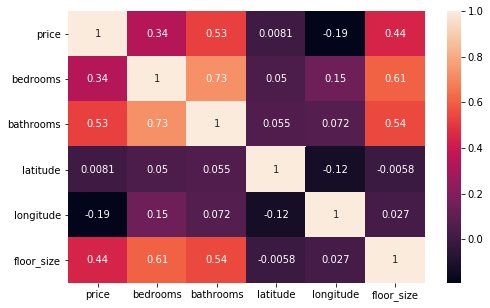

In [8]:
fig = plt.figure(figsize=(8,5))
sns.heatmap(df2.corr(),annot=True)

plt.show()

/Users/jacquelinewong/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


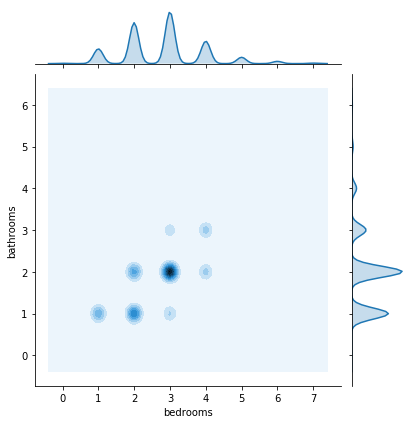

In [9]:
sns.jointplot(x='bedrooms',y='bathrooms',data=df2,kind='kde');

/Users/jacquelinewong/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


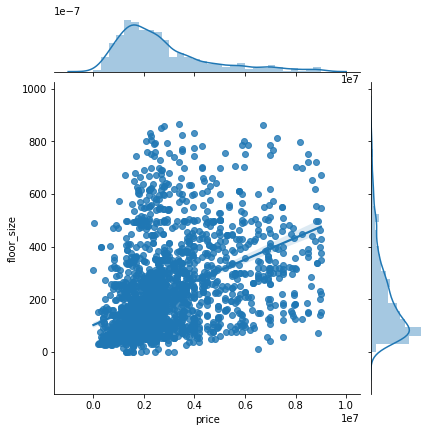

In [10]:
sns.jointplot(x='price',y='floor_size',data=df2,kind='reg');

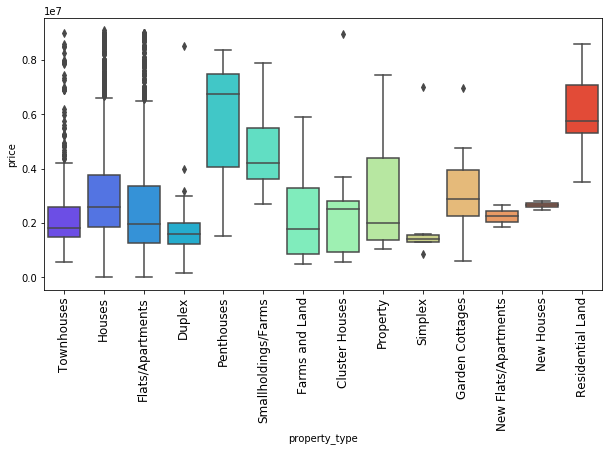

In [11]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(x="property_type", y="price", data=df2,palette='rainbow')
plt.xticks(rotation=90, size='large')

plt.show()

**Get the geograpical coordinate of Cape Town**

In [12]:
from geopy.geocoders import Nominatim
import requests
import folium

address = 'Cape Town, South Africa'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cape Town is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cape Town is -33.928992, 18.417396.


**Create a new column: binned_price**

`binned_price` will be displayed with markers of various color in the Folium

In [13]:
ncluster = 50

bins = list(np.linspace(df2.price.min(), df2.price.max(), num=ncluster))
df2['binned_price'] = np.searchsorted(bins, df2['price'])

/Users/jacquelinewong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(ncluster)
ys = [i + x + (i*x)**2 for i in range(ncluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# create map of Cape Town using latitude and longitude values
map_ct = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
markers_colors = []
for lat, lng, label, price in zip(df2['latitude'], df2['longitude'], df2['price'], df2['binned_price']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color=rainbow[int(price)-1],
        fill=True,
        fill_color=rainbow[int(price)-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_ct)  
    
map_ct

In [ ]:
from google.colab import files
df2.to_csv('cleaned_data.csv') 
files.download('cleaned_data.csv')

In [16]:
path='cape_town_map.html'
map_ct.save(path)